#  Notebook Description

The NB Fitting_Spectrum_test_multifeed_iminuit shows the aplication of fitting code to a toy 6-component background model, composed by 3 isotopes times 2 volumes. The fit is done simulaneously on E and Z 1D histograms, assuming the two to be uncorrelated. The fit is performed with iminuit. 

# Python Imports and Plotting Options

In [1]:
import time
import matplotlib.pylab as plt
#import scipy.optimize as sop
from iminuit import Minuit
import tables as tb
import pandas as pd
from Histogram import Histogram as hist
from PDF import PDF
import numpy as np
from Fits import Fit
from pprint import pprint # we use this to pretty print some stuff later

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 32, 24
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

print("Running on:", time.asctime())

Running on: Tue Jan 22 14:41:17 2019


# IPython Magic Commands 

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Preparation of DATA and MC samples

In [3]:
# Number of event per background component. First index is isotope type, second index is volume type. 
# This will be used as MC truth sample.
N_0_0 = 150000
N_0_1 = 350000
N_1_0 = 130000
N_1_1 = 270000
N_2_0 = 200000
N_2_1 = 300000

# Poisson smearing of number of events. This will be used as DATA-like sample.
N_0_0p = np.random.poisson(N_0_0)
N_0_1p = np.random.poisson(N_0_1)
N_1_0p = np.random.poisson(N_1_0)
N_1_1p = np.random.poisson(N_1_1)
N_2_0p = np.random.poisson(N_2_0)
N_2_1p = np.random.poisson(N_2_1)

In [4]:
# PDF for each background component drawn from some functions. Both for E and Z 1D histos. Draw Nsim events for each MC truth PDF
Nsim = int(1.e6)

# 
D_0_0_e_pdf = np.random.exponential(200,   Nsim)
D_0_0_z_pdf = np.random.normal     (30, 9, Nsim)

D_0_1_e_pdf = np.random.exponential(200,    Nsim)
D_0_1_z_pdf = np.random.normal     (90, 25, Nsim)

D_1_0_e_pdf = np.random.rayleigh   (500,    Nsim)
D_1_0_z_pdf = np.random.normal     (30, 9,  Nsim)

D_1_1_e_pdf = np.random.rayleigh   (500,    Nsim)
D_1_1_z_pdf = np.random.normal     (90, 25, Nsim)

D_2_0_e_pdf = np.random.chisquare  (1500,   Nsim)
D_2_0_z_pdf = np.random.normal     (30, 9,  Nsim)

D_2_1_e_pdf = np.random.chisquare  (1500,   Nsim)
D_2_1_z_pdf = np.random.normal     (90, 25, Nsim)

In [5]:
# This how DATA-like events are distributed in E and Z. 
# The PDFs arew the same as the MC truth ones, but number of events match DATA-like samples.
D_0_0_e = np.random.exponential(200,   N_0_0p)
D_0_0_z = np.random.normal     (30, 9, N_0_0p)

D_0_1_e = np.random.exponential(200,    N_0_1p)
D_0_1_z = np.random.normal     (90, 25, N_0_1p)

D_1_0_e = np.random.rayleigh   (500,    N_1_0p)
D_1_0_z = np.random.normal     (30, 9,  N_1_0p)

D_1_1_e = np.random.rayleigh   (500,    N_1_1p)
D_1_1_z = np.random.normal     (90, 25, N_1_1p)

D_2_0_e = np.random.chisquare  (1500,   N_2_0p)
D_2_0_z = np.random.normal     (30, 9,  N_2_0p)

D_2_1_e = np.random.chisquare  (1500,   N_2_1p)
D_2_1_z = np.random.normal     (90, 25, N_2_1p)


In [6]:
# The MC and DATA-like events are histogrammed in E and Z, assuming some number of bins, and histogram ranges.
nbin = 150
minE, maxE = 0, 2000
minZ, maxZ = 0, 150

# DATA-like
h_0_0_e = hist(D_0_0_e, nbin, minE, maxE)
h_0_0_z = hist(D_0_0_z, nbin, minZ, maxZ)
h_0_1_e = hist(D_0_1_e, nbin, minE, maxE)
h_0_1_z = hist(D_0_1_z, nbin, minZ, maxZ)
h_1_0_e = hist(D_1_0_e, nbin, minE, maxE)
h_1_0_z = hist(D_1_0_z, nbin, minZ, maxZ)
h_1_1_e = hist(D_1_1_e, nbin, minE, maxE)
h_1_1_z = hist(D_1_1_z, nbin, minZ, maxZ)
h_2_0_e = hist(D_2_0_e, nbin, minE, maxE)
h_2_0_z = hist(D_2_0_z, nbin, minZ, maxZ)
h_2_1_e = hist(D_2_1_e, nbin, minE, maxE)
h_2_1_z = hist(D_2_1_z, nbin, minZ, maxZ)

# MC
h_0_0_e_pdf = hist(D_0_0_e_pdf, nbin, minE, maxE)
h_0_0_z_pdf = hist(D_0_0_z_pdf, nbin, minZ, maxZ)
h_0_1_e_pdf = hist(D_0_1_e_pdf, nbin, minE, maxE)
h_0_1_z_pdf = hist(D_0_1_z_pdf, nbin, minZ, maxZ)
h_1_0_e_pdf = hist(D_1_0_e_pdf, nbin, minE, maxE)
h_1_0_z_pdf = hist(D_1_0_z_pdf, nbin, minZ, maxZ)
h_1_1_e_pdf = hist(D_1_1_e_pdf, nbin, minE, maxE)
h_1_1_z_pdf = hist(D_1_1_z_pdf, nbin, minZ, maxZ)
h_2_0_e_pdf = hist(D_2_0_e_pdf, nbin, minE, maxE)
h_2_0_z_pdf = hist(D_2_0_z_pdf, nbin, minZ, maxZ)
h_2_1_e_pdf = hist(D_2_1_e_pdf, nbin, minE, maxE)
h_2_1_z_pdf = hist(D_2_1_z_pdf, nbin, minZ, maxZ)

# In DATA-like, only know the sum of all background components
h_total_e = hist(np.concatenate([D_0_0_e, D_0_1_e, D_1_0_e, D_1_1_e, D_2_0_e, D_2_1_e]), nbin, minE, maxE)
h_total_z = hist(np.concatenate([D_0_0_z, D_0_1_z, D_1_0_z, D_1_1_z, D_2_0_z, D_2_1_z]), nbin, minZ, maxZ)

<ErrorbarContainer object of 3 artists>

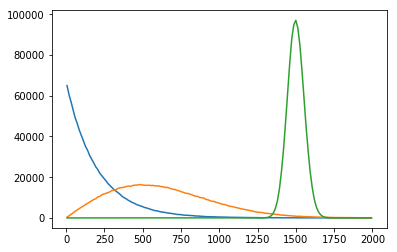

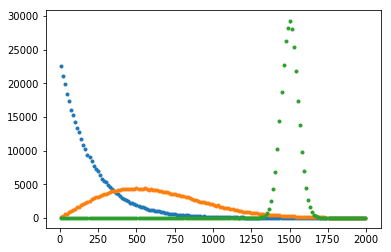

In [7]:
# MC truth energy histograms
plt.figure()
plt.plot(h_0_0_e.bins, h_0_0_e_pdf.hist)
plt.plot(h_1_0_e.bins, h_1_0_e_pdf.hist)
plt.plot(h_2_0_e.bins, h_2_0_e_pdf.hist)

# DATA-like energy histograms
plt.figure()
plt.errorbar(h_0_1_e.bins, h_0_1_e.hist, yerr=np.sqrt(h_0_1_e.hist), 
         marker='.', elinewidth=1, linewidth=0)
plt.errorbar(h_1_1_e.bins, h_1_1_e.hist, yerr=np.sqrt(h_1_1_e.hist),
             marker='.', elinewidth=1, linewidth=0)
plt.errorbar(h_2_1_e.bins, h_2_1_e.hist, yerr=np.sqrt(h_2_1_e.hist),
             marker='.', elinewidth=1, linewidth=0)

<ErrorbarContainer object of 3 artists>

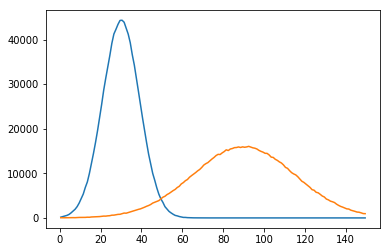

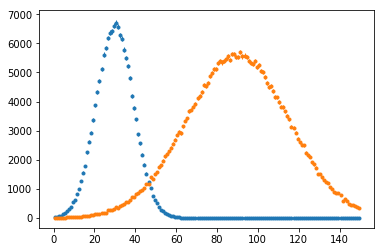

In [8]:
# MC truth Z histograms
plt.figure()
plt.plot(h_0_0_z.bins, h_0_0_z_pdf.hist)
plt.plot(h_0_1_z.bins, h_1_1_z_pdf.hist)

# DATA-like Z histograms
plt.figure()
plt.errorbar(h_0_0_z.bins, h_0_0_z.hist, yerr=np.sqrt(h_0_0_z.hist), 
         marker='.', elinewidth=1, linewidth=0)
plt.errorbar(h_0_1_z.bins, h_0_1_z.hist, yerr=np.sqrt(h_0_1_z.hist), 
         marker='.', elinewidth=1, linewidth=0)


In [9]:
# Make PDFs out of MC truth histograms. These are normalized to unity.
interpol = 'cubic'

pdf_0_0_e  = PDF(h_0_0_e_pdf, interpolation=interpol)
pdf_0_0_z  = PDF(h_0_0_z_pdf, interpolation=interpol)
pdf_0_1_e  = PDF(h_0_1_e_pdf, interpolation=interpol)
pdf_0_1_z  = PDF(h_0_1_z_pdf, interpolation=interpol)
pdf_1_0_e  = PDF(h_1_0_e_pdf, interpolation=interpol)
pdf_1_0_z  = PDF(h_1_0_z_pdf, interpolation=interpol)
pdf_1_1_e  = PDF(h_1_1_e_pdf, interpolation=interpol)
pdf_1_1_z  = PDF(h_1_1_z_pdf, interpolation=interpol)
pdf_2_0_e  = PDF(h_2_0_e_pdf, interpolation=interpol)
pdf_2_0_z  = PDF(h_2_0_z_pdf, interpolation=interpol)
pdf_2_1_e  = PDF(h_2_1_e_pdf, interpolation=interpol)
pdf_2_1_z  = PDF(h_2_1_z_pdf, interpolation=interpol)


pdf_list_e = [pdf_0_0_e, pdf_0_1_e, pdf_1_0_e, pdf_1_1_e, pdf_2_0_e, pdf_2_1_e]
pdf_list_z = [pdf_0_0_z, pdf_0_1_z, pdf_1_0_z, pdf_1_1_z, pdf_2_0_z, pdf_2_1_z]

In [10]:
# Build dictionaries
x_dict = {'E': h_0_0_e.bins , 'z': h_0_0_z.bins}
totals = {'E': h_total_e    , 'z': h_total_z   }
pdfs   = {'E': pdf_list_e   , 'z': pdf_list_z  }
N_0s   = np.array([N_0_0, N_0_1, N_1_0, N_1_1, N_2_0, N_2_1])
pprint(totals)
pprint(list(x_dict.keys()))
pprint(N_0s)
pprint(N_0s.reshape(len(N_0s), 1))

{'E': <Histogram.Histogram object at 0x1a23127be0>,
 'z': <Histogram.Histogram object at 0x1a231276d8>}
['E', 'z']
array([150000, 350000, 130000, 270000, 200000, 300000])
array([[150000],
       [350000],
       [130000],
       [270000],
       [200000],
       [300000]])


# Fit initialization

In [11]:
#Fit initialization
fit = Fit(x_dict, totals, pdfs, N_0s)
m = Minuit.from_array_func(fit.GetIminuitChi2, (1.,1.,1.,1.,1.,1.), error=0.1, limit=(0.1,10), errordef=1)
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,1,0.1,,,0.1,10,No
1,x1,1,0.1,,,0.1,10,No
2,x2,1,0.1,,,0.1,10,No
3,x3,1,0.1,,,0.1,10,No
4,x4,1,0.1,,,0.1,10,No
5,x5,1,0.1,,,0.1,10,No


# Migrad minimization

In [12]:
fmin, param = m.migrad()

FCN = 373.6699731701233 
 TOTAL NCALL = 1148 
 NCALLS = 1148 
 
 
 EDM = 2.3080701038599244e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,1.35669,0.341731,,,0.1,10,No
1,x1,0.847224,0.146626,,,0.1,10,No
2,x2,1.69915,0.310364,,,0.1,10,No
3,x3,0.657525,0.149461,,,0.1,10,No
4,x4,0.288128,0.262895,,,0.1,10,No
5,x5,1.4706,0.176309,,,0.1,10,No


In [13]:
# Note that m.values returns a dictionary of {'name',value} pairs. 
# By asking for m.values.values(), we only return the values
result = np.array(m.values.values())
pprint(result)

array([1.35669341, 0.84722355, 1.69914724, 0.65752541, 0.28812769,
       1.4706016 ])


In [14]:
factors = result * N_0s

interpol = 'nearest'

pdf_0_0_ep  = PDF(h_0_0_e_pdf, factor=factors[0]  ,interpolation=interpol)
pdf_0_1_ep  = PDF(h_0_1_e_pdf, factor=factors[1]  ,interpolation=interpol)
pdf_1_0_ep  = PDF(h_1_0_e_pdf, factor=factors[2]  ,interpolation=interpol)
pdf_1_1_ep  = PDF(h_1_1_e_pdf, factor=factors[3]  ,interpolation=interpol)
pdf_2_0_ep  = PDF(h_2_0_e_pdf, factor=factors[4]  ,interpolation=interpol)
pdf_2_1_ep  = PDF(h_2_1_e_pdf, factor=factors[5]  ,interpolation=interpol)

pdf_0_0_zp  = PDF(h_0_0_z_pdf, factor=factors[0]  ,interpolation=interpol)
pdf_0_1_zp  = PDF(h_0_1_z_pdf, factor=factors[1]  ,interpolation=interpol)
pdf_1_0_zp  = PDF(h_1_0_z_pdf, factor=factors[2]  ,interpolation=interpol)
pdf_1_1_zp  = PDF(h_1_1_z_pdf, factor=factors[3]  ,interpolation=interpol)
pdf_2_0_zp  = PDF(h_2_0_z_pdf, factor=factors[4]  ,interpolation=interpol)
pdf_2_1_zp  = PDF(h_2_1_z_pdf, factor=factors[5]  ,interpolation=interpol)

pprint(pdf_0_0_ep)
pprint(result)
pprint(N_0s)
pprint(factors)

array([1.35669341, 0.84722355, 1.69914724, 0.65752541, 0.28812769,
       1.4706016 ])
array([150000, 350000, 130000, 270000, 200000, 300000])
array([203504.01152861, 296528.24320507, 220889.14164281, 177531.86096065,
        57625.538767  , 441180.48116542])


In [15]:
# h_0_0_e.bins[0] and h_0_0_e.bins[-1] are bin central values of first and last bin, respectively. Same for z
# Ep and Zp return 1000 evenly-spaced numbers over this interval
Ep = np.linspace(h_0_0_e.bins[0],h_0_0_e.bins[-1],1000)
Zp = np.linspace(h_0_0_z.bins[0],h_0_0_z.bins[-1],1000)

y_0_0_e = pdf_0_0_ep.pdf(Ep)
y_0_1_e = pdf_0_1_ep.pdf(Ep)
y_1_0_e = pdf_1_0_ep.pdf(Ep)
y_1_1_e = pdf_1_1_ep.pdf(Ep)
y_2_0_e = pdf_2_0_ep.pdf(Ep)
y_2_1_e = pdf_2_1_ep.pdf(Ep)

y_0_0_z = pdf_0_0_zp.pdf(Zp)
y_0_1_z = pdf_0_1_zp.pdf(Zp)
y_1_0_z = pdf_1_0_zp.pdf(Zp)
y_1_1_z = pdf_1_1_zp.pdf(Zp)
y_2_0_z = pdf_2_0_zp.pdf(Zp)
y_2_1_z = pdf_2_1_zp.pdf(Zp)


fittotal_e = y_0_0_e + y_0_1_e + y_1_0_e + y_1_1_e + y_2_0_e + y_2_1_e
fittotal_z = y_0_0_z + y_0_1_z + y_1_0_z + y_1_1_z + y_2_0_z + y_2_1_z

fit_0_a_e = y_0_0_e + y_0_1_e 
fit_1_a_e = y_1_0_e + y_1_1_e 
fit_2_a_e = y_2_0_e + y_2_1_e 

fit_a_0_z = y_0_0_z + y_1_0_z + y_2_0_z 
fit_a_1_z = y_0_1_z + y_1_1_z + y_2_1_z 


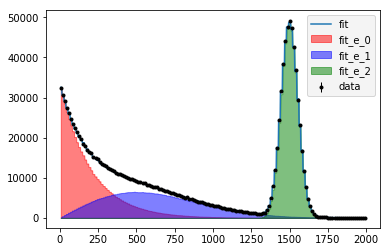

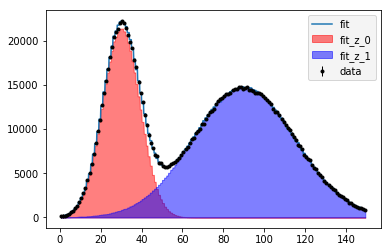

In [16]:
alfa= 0.5
#plt.semilogy()
#plt.ylim(1e-1,2e5)

plt.figure()
plt.errorbar(h_total_e.bins, h_total_e.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Ep, fittotal_e,label='fit')

plt.fill_between(Ep, 0 , fit_0_a_e, label='fit_e_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , fit_1_a_e, label='fit_e_1',alpha=alfa,color='b')
plt.fill_between(Ep, 0 , fit_2_a_e, label='fit_e_2',alpha=alfa,color='g')

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')

plt.legend().get_frame().set_facecolor('0.95')


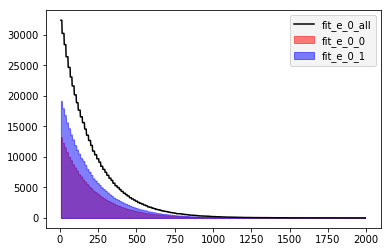

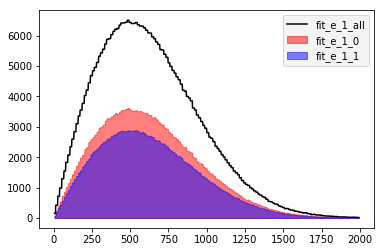

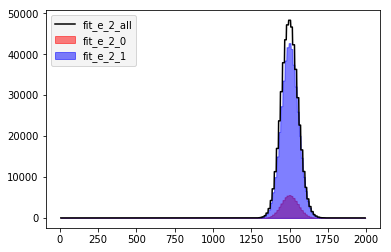

In [17]:
plt.figure()

plt.plot(Ep, fit_0_a_e,label='fit_e_0_all', color='black')
plt.fill_between(Ep, 0 , y_0_0_e, label='fit_e_0_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , y_0_1_e, label='fit_e_0_1',alpha=alfa,color='b')
plt.legend().get_frame().set_facecolor('0.95')

plt.figure()

plt.plot(Ep, fit_1_a_e,label='fit_e_1_all', color='black')
plt.fill_between(Ep, 0 , y_1_0_e, label='fit_e_1_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , y_1_1_e, label='fit_e_1_1',alpha=alfa,color='b')
plt.legend().get_frame().set_facecolor('0.95')

plt.figure()

plt.plot(Ep, fit_2_a_e,label='fit_e_2_all', color='black')
plt.fill_between(Ep, 0 , y_2_0_e, label='fit_e_2_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , y_2_1_e, label='fit_e_2_1',alpha=alfa,color='b')
plt.legend().get_frame().set_facecolor('0.95')


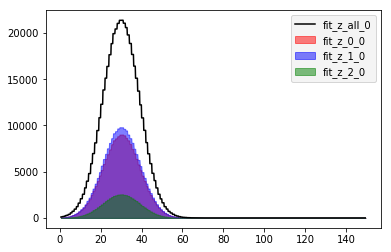

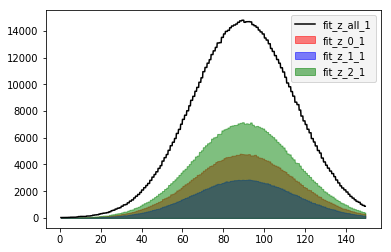

In [18]:
plt.figure()

plt.plot(Zp, fit_a_0_z,label='fit_z_all_0', color='black')
plt.fill_between(Zp, 0 , y_0_0_z, label='fit_z_0_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , y_1_0_z, label='fit_z_1_0',alpha=alfa,color='b')
plt.fill_between(Zp, 0 , y_2_0_z, label='fit_z_2_0',alpha=alfa,color='g')
plt.legend().get_frame().set_facecolor('0.95')

plt.figure()

plt.plot(Zp, fit_a_1_z,label='fit_z_all_1', color='black')
plt.fill_between(Zp, 0 , y_0_1_z, label='fit_z_0_1',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , y_1_1_z, label='fit_z_1_1',alpha=alfa,color='b')
plt.fill_between(Zp, 0 , y_2_1_z, label='fit_z_2_1',alpha=alfa,color='g')
plt.legend().get_frame().set_facecolor('0.95')

# Minos minimization

In [19]:
param = m.minos()

Error,-0.2964678116175399,0.2968125995119381
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.127190936410252,0.12704395359856438
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.28520766306061585,0.28518803480222943
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.13715824921528572,0.13727512834301564
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.1881276938349897,0.21786210908577985
Valid,True,True
At Limit,True,False
Max FCN,False,False
New Min,False,False


Error,-0.1452465429844695,0.12641445621070727
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


# Goodness-of-fit

# Parameter uncertainties, covariances, and confidence intervals

In [21]:
param = m.hesse()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,1.35669,0,-0.296468,0.296813,0.1,10,No
1,x1,0.847224,0,-0.127191,0.127044,0.1,10,No
2,x2,1.69915,0,-0.285208,0.285188,0.1,10,No
3,x3,0.657525,0,-0.137158,0.137275,0.1,10,No
4,x4,0.288128,0,-0.188128,0.217862,0.1,10,No
5,x5,1.4706,0,-0.145247,0.126414,0.1,10,No


RuntimeError: Covariance is not valid. May be the last Hesse call failed?

In [22]:
pprint('Covariance mattrix as numpy array:')
pprint(m.np_matrix())

pprint('Correlation matrix as numpy array:')
pprint(m.np_matrix(correlation=True))

'Covariance mattrix as numpy array:'


RuntimeError: Covariance is not valid. May be the last Hesse call failed?

In [23]:
# Parameter scans around chi2 minimum
x0, fx0 = m.profile('x0', subtract_min=True)
plot(x0, fx0);

TypeError: GetIminuitChi2() takes 2 positional arguments but 7 were given

In [24]:
#m.draw_contour('x0','x1');
x,y,z = m.contour('x0', 'x1', subtract_min=True)
cs = contour(x,y,z, (1, 2, 3, 4))
clabel(cs);

TypeError: GetIminuitChi2() takes 2 positional arguments but 7 were given

IndexError: list index out of range

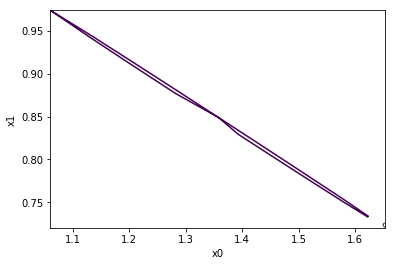

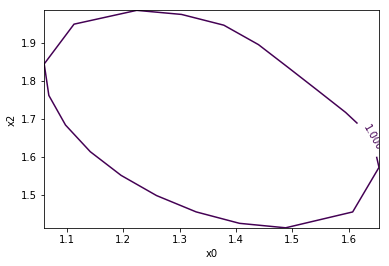

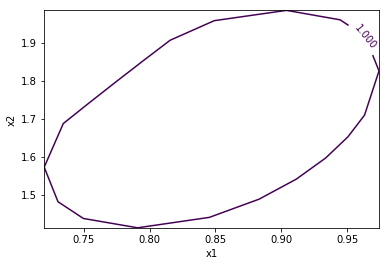

<Figure size 432x288 with 0 Axes>

In [25]:
plt.figure()
m.draw_mncontour('x0','x1', nsigma=1);  # nsigma=1 says: draw one contour for sigma=1
plt.figure()
m.draw_mncontour('x0','x2', nsigma=1); 


plt.figure()
m.draw_mncontour('x1','x2', nsigma=1); 
plt.figure()
m.draw_mncontour('x1','x3', nsigma=1); 

plt.figure()
m.draw_mncontour('x2','x3', nsigma=1); 
plt.figure()
m.draw_mncontour('x2','x4', nsigma=1); 


plt.figure()
m.draw_mncontour('x3','x4', nsigma=1); 

plt.figure()
m.draw_mncontour('x4','x5', nsigma=1); 